In [ ]:
# code modded from
# https://github.com/matteoferla/pyrosetta-help/blob/main/colab_notebooks/colab-pyrosetta-migrate_ligands.ipynb
# to do add chemical component kill list: https://blog.matteoferla.com/2019/11/go-away-glycerol.html
# ligand extaction code is non-covalent version



In [ ]:
import os
from pathlib import Path
root = Path('/Users/user/Coding/EV-D68-3C-protease/')
os.chdir(root)

In [ ]:
import pymol2

with pymol2.PyMOL() as pymol:
    pymol.cmd.load('reference.pdb')
    fasta: str = pymol.cmd.get_fastastr('reference')
    seq: str = ''.join(fasta.split('\n')[1:])

print(len(seq), set(seq))

In [ ]:
#@title Find related structures in the PDB
import pyrosetta_help as ph

acceptor_chain = 'A'

print('blasting sequence...')
hunter = ph.LigandHunter(seq)
print('Most common ligands:')
for lig, c in hunter.get_most_common_ligands()[:10]:
    print(lig, c, hunter.ligand_data[lig][0]['name'])
df = hunter.to_dataframe()
df.to_csv('blast_hits.csv')
df

In [ ]:
import chempy
from typing import List, Set, Dict
fluff_marker = '§'  # name + fluff + index, say MPRO-x0102_0B§1
from collections import defaultdict

pdb_blocks: Dict[str, str] = {}
details: Dict[str, Dict] = {}
chemcomp_tally = defaultdict(int)
with pymol2.PyMOL() as pymol:
    pymol.cmd.set('pdb_conect_all', 'on')
    pymol.cmd.load('reference.pdb')
    for i, row in df.iterrows():
        pymol.cmd.fetch(row.pdb_code)
        pymol_name = row.pdb_code
        xstal_name = row.pdb_code
        pymol.cmd.align(f'%{row.pdb_code} and chain {row.chain}', 'reference')
        for lig_resn in set(row.ligand_codes):
            # ## Determine what is unique ligand residue
            # get atoms of ligand
            lig_atoms: List[chempy.Atom] = pymol.cmd.get_model(f'%{pymol_name} and resn {lig_resn}').atom
            # get set of tuple of resi chain segi alt
            selectors: Set[tuple] = {(atom.resi, atom.chain, atom.segi, atom.alt) for atom in lig_atoms}
            # iterate for all unique
            for resi, chain, segi, alt in selectors:
                sele = f'%{pymol_name} and resn {lig_resn} and resi {resi}'
                if chain:
                    sele+= f' and chain {chain}'
                if segi:
                    sele+= f' and segi {segi}'
                if alt:
                    sele+= f' and alt {alt}'
                # MOD: no asymmetric chain business here: too dangerous
                xsele = f'(not ({sele})) and bound_to ({sele})'
                covalency = False
                if pymol.cmd.count_atoms(xsele):
                    # crosslink
                    covalency = True
                    pymol.cmd.alter(xsele, 'elem="T"')  # Chem.MolFromPDBBlock does not like *, R, X
                    pymol.cmd.alter(xsele, 'name = " X  "')
                    pymol.cmd.sort()
                pymol.cmd.create('copied', f'bound_to ({sele})')
                pymol.cmd.alter('%copied', 'alt=""')
                pymol.cmd.alter('%copied', 'segi=""')
                pymol.cmd.alter('%copied', 'chain="X"')
                pymol.cmd.alter('%copied', 'resi="1"')
                pymol.cmd.alter('%copied', f'resn="LIG"')
                pymol.cmd.sort()
                # MOD
                #neoname = f'{xstal_name}{fluff_marker}{i}'
                chemcomp_tally[lig_resn] += 1
                neoname = f'{lig_resn}{fluff_marker}{chemcomp_tally[lig_resn]}'
                pdb_blocks[neoname] = pymol.cmd.get_pdbstr('%copied').replace('ATOM  ', 'HETATM')
                pymol.cmd.delete('copied')
                details[neoname] = {**row.to_dict(),  # mod
                                    'covalent': covalency,
                                    **dict(base_name=xstal_name,
                                        lig_resn=lig_resn,
                                         lig_resi=resi,
                                         lig_chain=chain,
                                         lig_segi=segi,
                                         lig_alt=alt,
                                         polymer_chain='A',)  # mod
                                    }


In [ ]:
# HACK FOR POLYMER

from collections import defaultdict

with pymol2.PyMOL() as pymol:
    pymol.cmd.load('reference.pdb')
    xstal_name = '2b0f'
    pymol.cmd.fetch(xstal_name)
    pymol.cmd.align(f'%{xstal_name} and chain A', 'reference')
    pymol.cmd.delete('reference')
    pymol.cmd.remove('chain A')
    atom_tally = defaultdict(int)
    for atom in pymol.cmd.get_model('chain B').atom:
        atom_tally[atom.symbol] += 1
        pymol.cmd.alter(f'name {atom.name}', f'name="{atom.symbol: >2}{atom_tally[atom.symbol]: <2}"')
    pymol.cmd.alter('*', 'alt=""')
    pymol.cmd.alter('*', 'segi=""')
    pymol.cmd.alter('*', 'chain="X"')
    pymol.cmd.alter('*', 'resi="1"')
    pymol.cmd.alter('*', 'resn="LIG"')
    pymol.cmd.sort()
    neoname='polymer'
    pymol.cmd.set('pdb_conect_all', 'on')
    pdb_blocks[neoname] = pymol.cmd.get_pdbstr('*').replace('ATOM  ', 'HETATM')
    details[neoname] = dict(base_name=xstal_name,
                                        lig_resn=None,
                                         lig_resi=1,
                                         lig_chain='B',
                                         lig_segi='',
                                         lig_alt='',
                                         polymer_chain='A',)

In [193]:
smilesdex = {detail['lig_resn']: ph.get_smiles(detail['lig_resn']) for detail in details.values() if detail['lig_resn'] != 'LIG' and detail['lig_resn'] != 'UNL' and detail['lig_resn'] is not None}

In [204]:
smilesdex['polymer'] = 'CCOC(=O)C=C[C@H](CCC(N)=O)NC(=O)[C@H](Cc1ccccc1)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](C)NC(=O)[C@H](CCC([O-])=O)NC(=O)[C@H](CC(C)C)NC(C)=O'

In [205]:
for detail in details.values():
    detail['single_smiles'] = smilesdex.get(detail['lig_resn'], None)

In [206]:
import json
import pickle
from rdkit import Chem
from rdkit.Chem import AllChem, Draw

smiles_col_name = 'single_smiles'

mols = []
baddies = []
inorganics = []
broken = []
for name, block in pdb_blocks.items():
    if block.strip().count('\n') == 0:
        print(f'No atoms in {name}')
        broken.append(name)
        continue
    detail: dict = details[name]
    mol = Chem.MolFromPDBBlock(block, proximityBonding='CONECT' not in block)
    if mol is None:
        print(f'Issue with sanitisation, trying without for {name}')
        mol = Chem.MolFromPDBBlock(block, proximityBonding='CONECT' not in block, sanitize=False)
    if len(mol.GetAtomsMatchingQuery(AllChem.AtomNumEqualsQueryAtom(6))) == 0:
        print(f'No carbon atoms in {name}')
        inorganics.append(name)
        continue
    tritium = mol.GetAtomsMatchingQuery(AllChem.IsotopeEqualsQueryAtom(3))
    for atom in tritium:  #: Chem.Atom
        atom.SetIsotope(0)
        atom.SetAtomicNum(0)  # dummy atom is zahl zero
    assert mol, f'{name} failed to load'
    # MOD
    #assert mol.GetNumAtoms() > 0 and mol.GetNumBonds() > 0, f'{name} failed to load'
    assert mol.GetNumAtoms() > 0, f'{name} failed to load'
    smiles = detail[smiles_col_name]
    if smiles is None:
        smiles=''
    ref = Chem.MolFromSmiles(smiles)
    try:
        mol = AllChem.AssignBondOrdersFromTemplate(ref, mol)
    except Exception as e:
        print(f'Issue with bond orders for {name} - {e.__class__.__name__}{e}')
        baddies.append(dict(name=name, block=block, mol=mol, ref=ref, detail=detail, exception=e))
        # continue # MOD: These are PDB depositions they have bond order.
    mol.SetProp('XChem_code', name.split('_')[0])
    mol.SetProp('Occupancy', json.dumps([a.GetPDBResidueInfo().GetOccupancy() for a in mol.GetAtoms()]) )
    mol.SetProp('TempFactor', json.dumps([a.GetPDBResidueInfo().GetTempFactor() for a in mol.GetAtoms()]) )
    unprefixed = name.replace('D68EV3CPROA-', '')
    mol.SetProp('_Name', unprefixed)
    for k, v in detail.items():
        if isinstance(v, dict):
            v = json.dumps(v)
        mol.SetProp(k, str(v))
    for atom in mol.GetAtoms():
        name = atom.GetPDBResidueInfo().GetName()
        atom.SetProp('molFileAlias', name)
    mols.append(mol)

assert mols, 'No mols!'

[13:07:58] WARNING: More than one matching pattern found - picking one

[13:07:58] WARNING: More than one matching pattern found - picking one

[13:07:58] WARNING: More than one matching pattern found - picking one

[13:07:58] Explicit valence for atom # 4 C, 5, is greater than permitted
[13:07:58] WARNING: More than one matching pattern found - picking one

[13:07:58] Explicit valence for atom # 43 H, 3, is greater than permitted
[13:07:58] WARNING: More than one matching pattern found - picking one

[13:07:58] WARNING: More than one matching pattern found - picking one

[13:07:58] WARNING: not removing hydrogen atom without neighbors
[13:07:58] WARNING: More than one matching pattern found - picking one

[13:07:58] WARNING: More than one matching pattern found - picking one

[13:07:58] WARNING: More than one matching pattern found - picking one

[13:07:58] WARNING: More than one matching pattern found - picking one

[13:07:58] WARNING: More than one matching pattern found - picking o

No atoms in DTZ§1
Issue with bond orders for I70§1 - AtomValenceExceptionExplicit valence for atom # 4 C, 5, is greater than permitted
No carbon atoms in PI§1
No carbon atoms in PI§2
No carbon atoms in PI§3
Issue with bond orders for XNV§1 - ValueErrorNo matching found
Issue with bond orders for XNV§3 - ValueErrorNo matching found
Issue with bond orders for XNV§4 - ValueErrorNo matching found
Issue with sanitisation, trying without for XNV§5
Issue with bond orders for XNV§5 - ValueErrorNo matching found
Issue with bond orders for XNV§6 - ValueErrorNo matching found
No atoms in NH4§1
No atoms in NH4§2
No atoms in NH4§3
No atoms in CL§1
No atoms in MG§1
No atoms in MG§2
No carbon atoms in SO4§1
No carbon atoms in SO4§2
Issue with bond orders for DTT§1 - ValueErrorNo matching found
Issue with bond orders for K36§1 - ValueErrorNo matching found
No carbon atoms in SO4§3
No carbon atoms in SO4§4
No carbon atoms in SO4§5
No carbon atoms in SO4§6
No carbon atoms in SO4§7
No carbon atoms in SO4

[13:07:58] WARNING: More than one matching pattern found - picking one

[13:07:58] WARNING: More than one matching pattern found - picking one

[13:07:58] WARNING: More than one matching pattern found - picking one

[13:07:58] WARNING: More than one matching pattern found - picking one

[13:07:58] WARNING: More than one matching pattern found - picking one

[13:07:58] WARNING: More than one matching pattern found - picking one

[13:07:58] Explicit valence for atom # 31 H, 2, is greater than permitted
[13:07:58] WARNING: More than one matching pattern found - picking one

[13:07:58] Explicit valence for atom # 26 C, 5, is greater than permitted
[13:07:58] WARNING: More than one matching pattern found - picking one

[13:07:58] WARNING: More than one matching pattern found - picking one

[13:07:58] WARNING: More than one matching pattern found - picking one

[13:07:59] WARNING: More than one matching pattern found - picking one

[13:07:59] WARNING: More than one matching pattern found - p

/Users/user/.conda/envs/py310/lib/python3.10/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


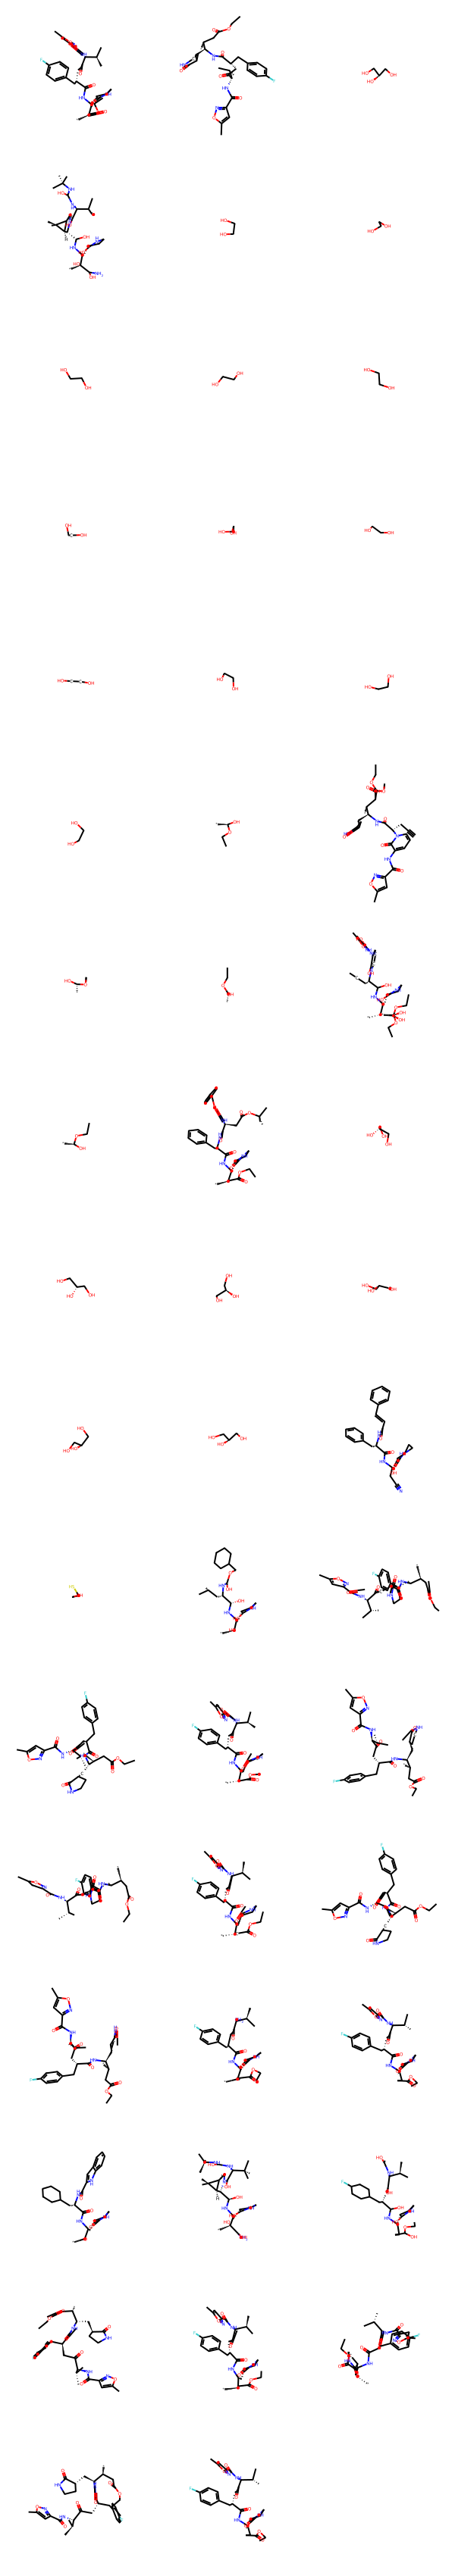

In [207]:
Draw.MolsToGridImage(mols)

In [208]:
broken

['DTZ§1', 'NH4§1', 'NH4§2', 'NH4§3', 'CL§1', 'MG§1', 'MG§2', 'ZN§2', 'NA§1']

In [209]:
inorganics

['PI§1',
 'PI§2',
 'PI§3',
 'SO4§1',
 'SO4§2',
 'SO4§3',
 'SO4§4',
 'SO4§5',
 'SO4§6',
 'SO4§7',
 'SO4§8',
 'SO4§9',
 'SO4§10',
 'ZN§1',
 'SO4§11',
 'SO4§12',
 'SO4§13',
 'SO4§14']

In [210]:
import operator

*map(operator.itemgetter('name'), baddies),

('I70§1',
 'XNV§1',
 'XNV§3',
 'XNV§4',
 'XNV§5',
 'XNV§6',
 'DTT§1',
 'K36§1',
 'I70§2',
 'AG7§12',
 '5GI§2',
 'polymer')

In [211]:
# Save

with Chem.SDWriter('stolen_hits.sdf') as sdf:
    for mol in mols:
        if mol is None:
            continue
        sdf.write(mol)

In [212]:
!rm *.cif

In [175]:
import clipboard

clipboard.copy(Chem.MolToSmiles(mols[-1]))
Chem.MolToSmiles(mols[-1])

'CCOC(O)CC[C@H](CCC(N)O)NC(O)[C@H](CC1CCCCC1)NC(O)[C@H](CC(C)C)NC(O)[C@H](C)N[C@H](O)[C@H](CCC([O-])O)NC(O)[C@H](CC(C)C)N[C@H](C)O'

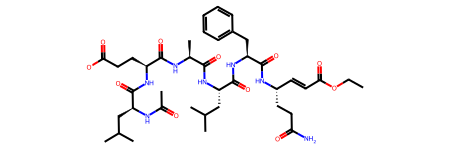

In [203]:
Chem.MolFromSmiles('CCOC(=O)C=C[C@H](CCC(N)=O)NC(=O)[C@H](Cc1ccccc1)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](C)NC(=O)[C@H](CCC([O-])=O)NC(=O)[C@H](CC(C)C)NC(C)=O')

ModuleNotFoundError: No module named 'clipboard'